In [1]:
import cv2
import einops
import torch
import torch.nn as nn
import torchvision.transforms.functional as tf
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.auto import tqdm

from model import CNNModel

In [2]:
bad_tiles = cv2.imread("data/bad_tiles.png", cv2.IMREAD_GRAYSCALE)
bad_tiles = einops.rearrange(bad_tiles, "(h h1) (w w1) -> (h w) h1 w1", h1=15, w1=15)
bad_tiles = torch.stack(
    [tf.resize(tf.to_tensor(tile), (21, 21), antialias=True) for tile in bad_tiles]
)

good_tiles = cv2.imread("data/good_tiles.png", cv2.IMREAD_GRAYSCALE)
good_tiles = einops.rearrange(good_tiles, "(h h1) (w w1) -> (h w) h1 w1", h1=15, w1=15)
good_tiles = torch.stack(
    [tf.resize(tf.to_tensor(tile), (21, 21), antialias=True) for tile in good_tiles]
)

bad_labels = torch.zeros(bad_tiles.size(0), dtype=torch.int64)
good_labels = torch.ones(good_tiles.size(0), dtype=torch.int64)

images = torch.cat([good_tiles, bad_tiles], dim=0)
labels = torch.cat([good_labels, bad_labels], dim=0)

In [3]:
dataset = TensorDataset(images, labels)

In [4]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1], generator)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [5]:
device = "cpu"
model = CNNModel([32, 64, 1024])
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [6]:
losses = []
model.train()
epochs = 5

for epoch in range(epochs):
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)

        pred = model(2 * image - 1)
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    model.eval()
    count = 0

    for image, label in tqdm(val_loader):
        image = image.to(device)
        label = label.to(device)

        with torch.no_grad():
            probs = model(2 * image - 1).softmax(dim=1)

        count += torch.sum(label.to(torch.bool) == (probs[:, 1] > 0.5)).item()

    accuracy = count / len(val_dataset)
    print(epoch, accuracy)

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

0 0.963097033685269


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

1 0.9712418300653595


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

2 0.9721468074409251


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

3 0.9733534439416792


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

4 0.9733534439416792


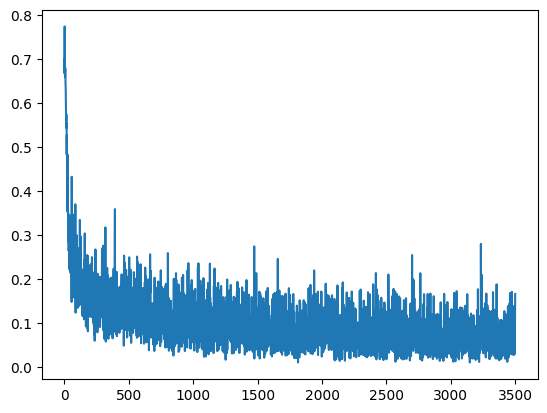

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [8]:
torch.save(model.state_dict(), "model.pt")